## Metrics

汇总常见2分类的指标，例如: AUC，ROC曲线，ACC, 敏感性， 特异性，精确度，召回率，PPV, NPV, F1

具体的介绍，可以参考一下：https://blog.csdn.net/sunflower_sara/article/details/81214897

In [1]:
import pandas as pd
import os
from onekey_algo import get_param_in_cwd

group = pd.read_csv('data/path_ids.csv', dtype={'ID': str})
# group['ID'] = group['ID'].map(lambda x: x.replace('v.nii.gz', ''))
group

,ID,group
0,1.nii.gz,train
1,10.nii.gz,train
2,100.nii.gz,train
3,101.nii.gz,train
4,102.nii.gz,train
...,...,...
189,87.nii.gz,test
190,9.nii.gz,test
191,91.nii.gz,test
192,96.nii.gz,test


 29 8 train (1268349, 7)
 29 8 test (421943, 7)


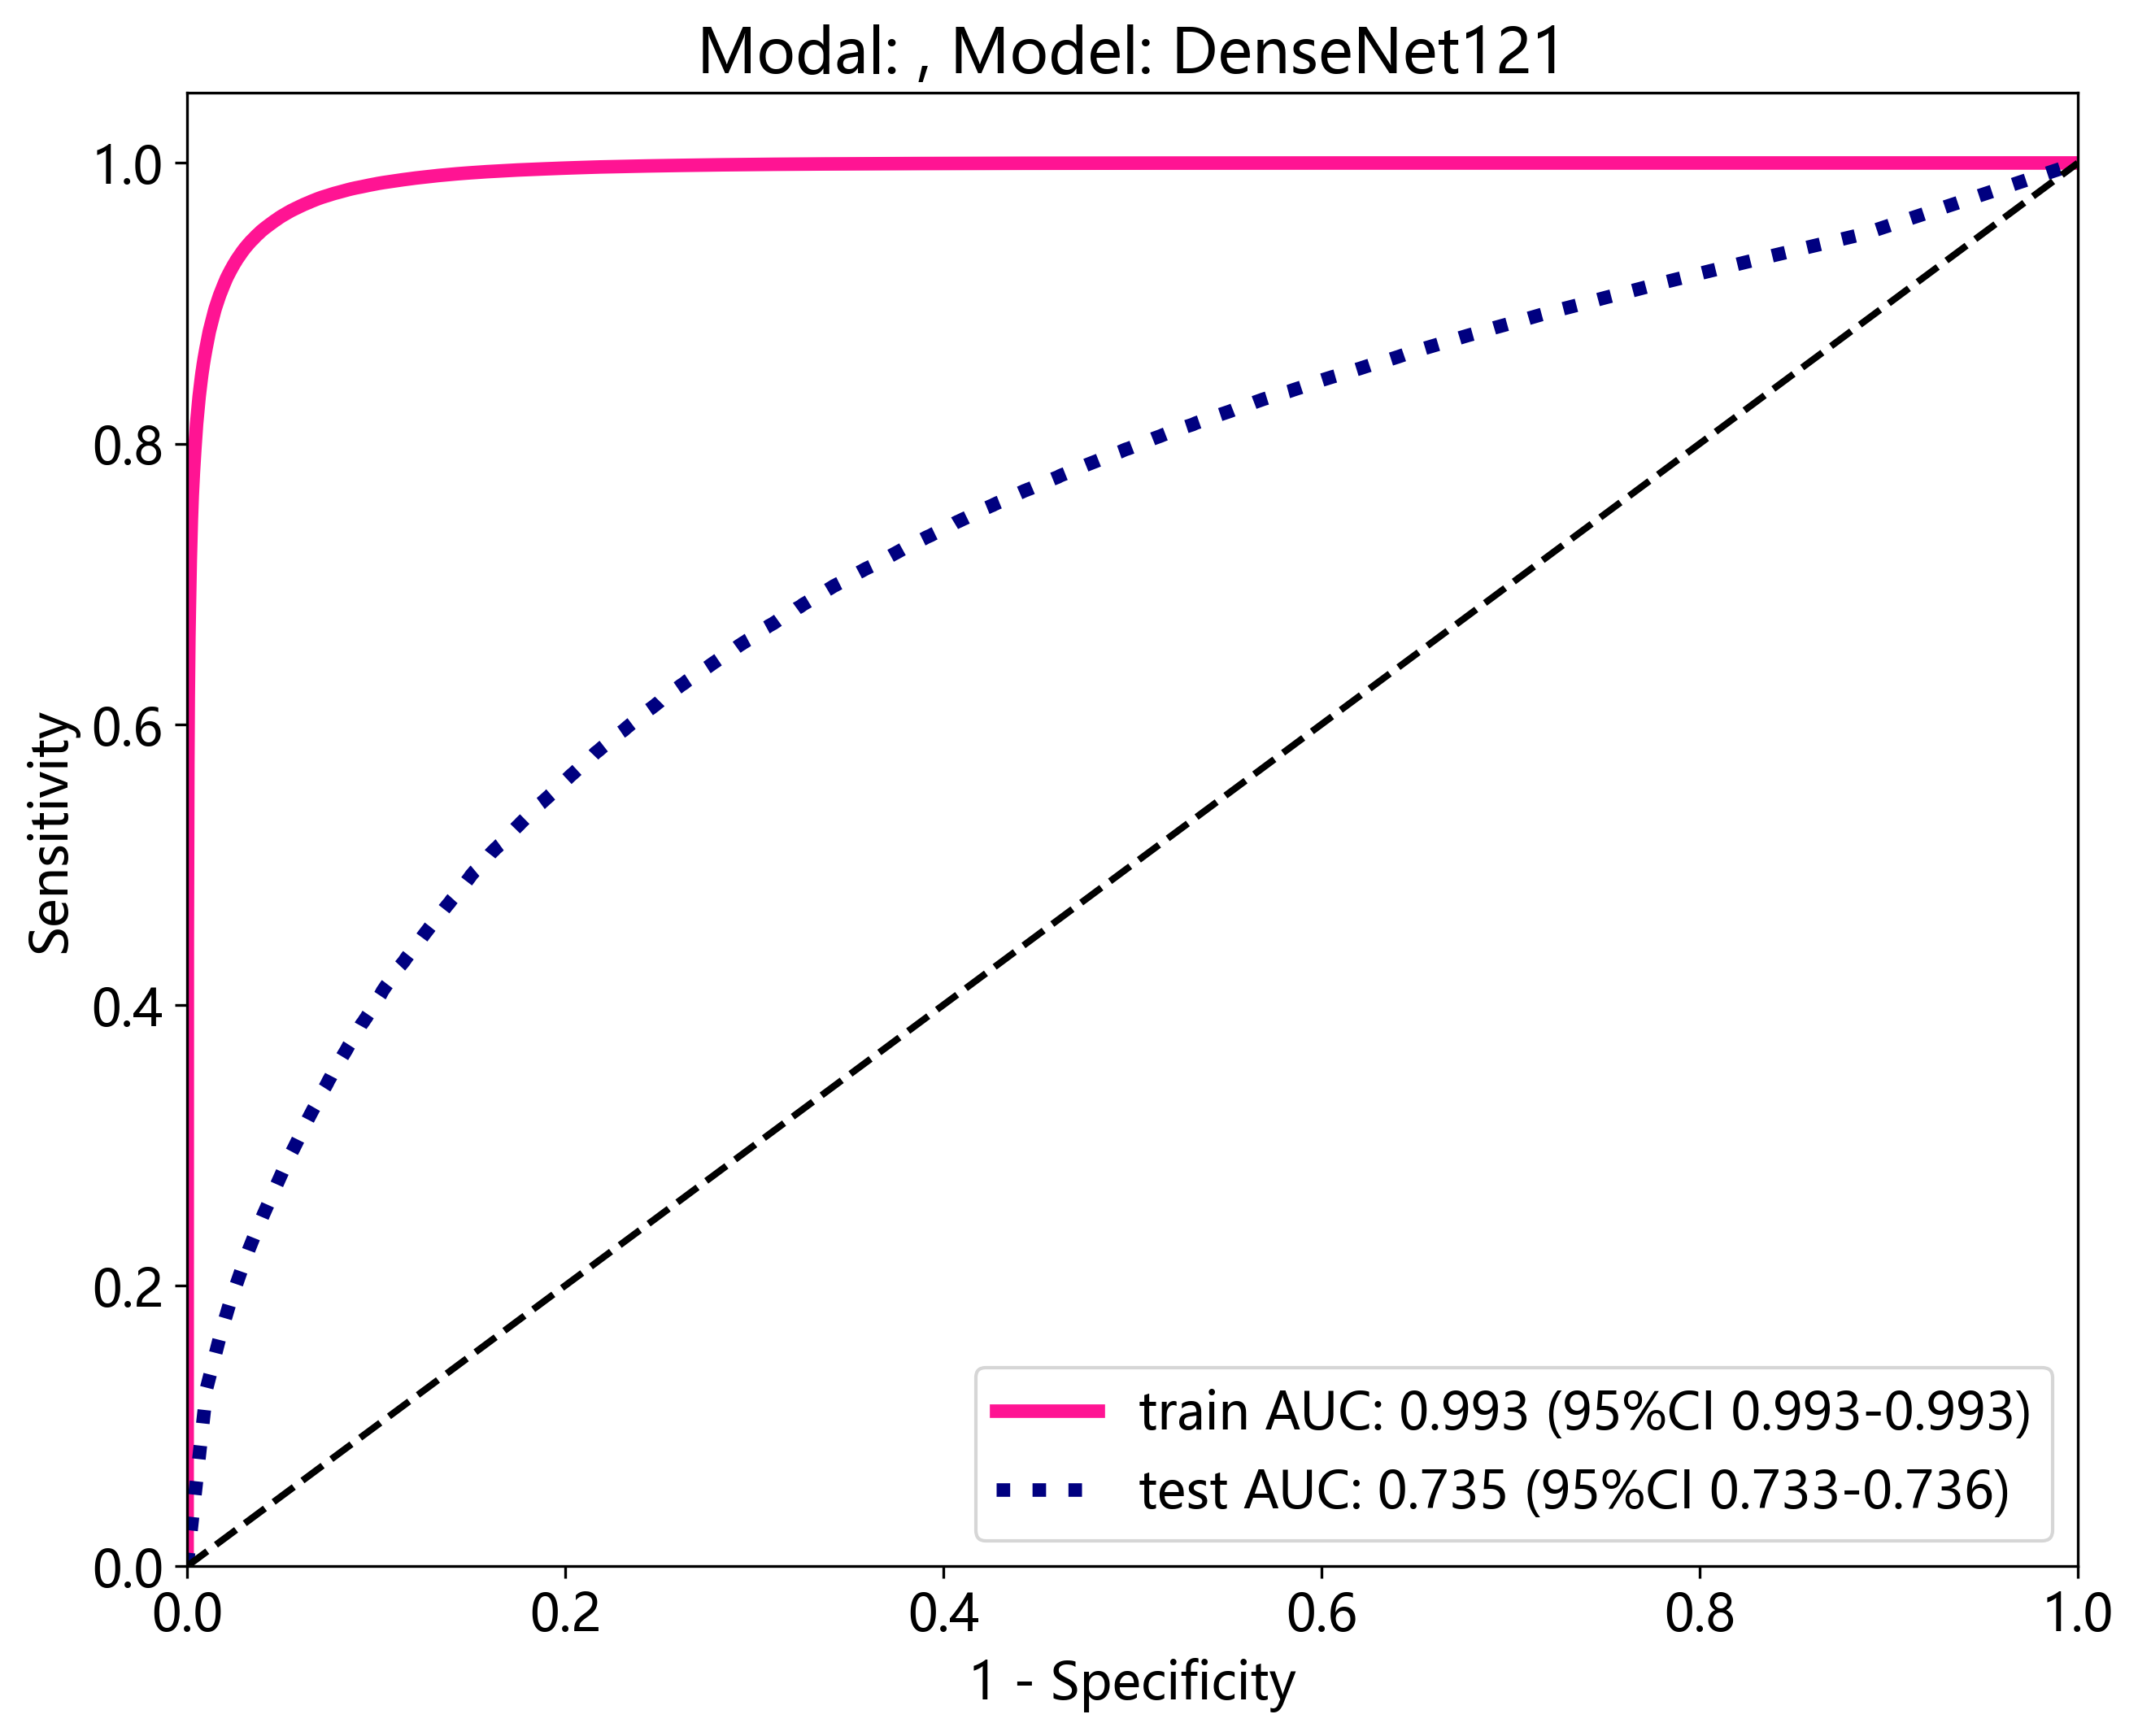

 29 8 train (1268349, 7)
 29 8 test (421943, 7)


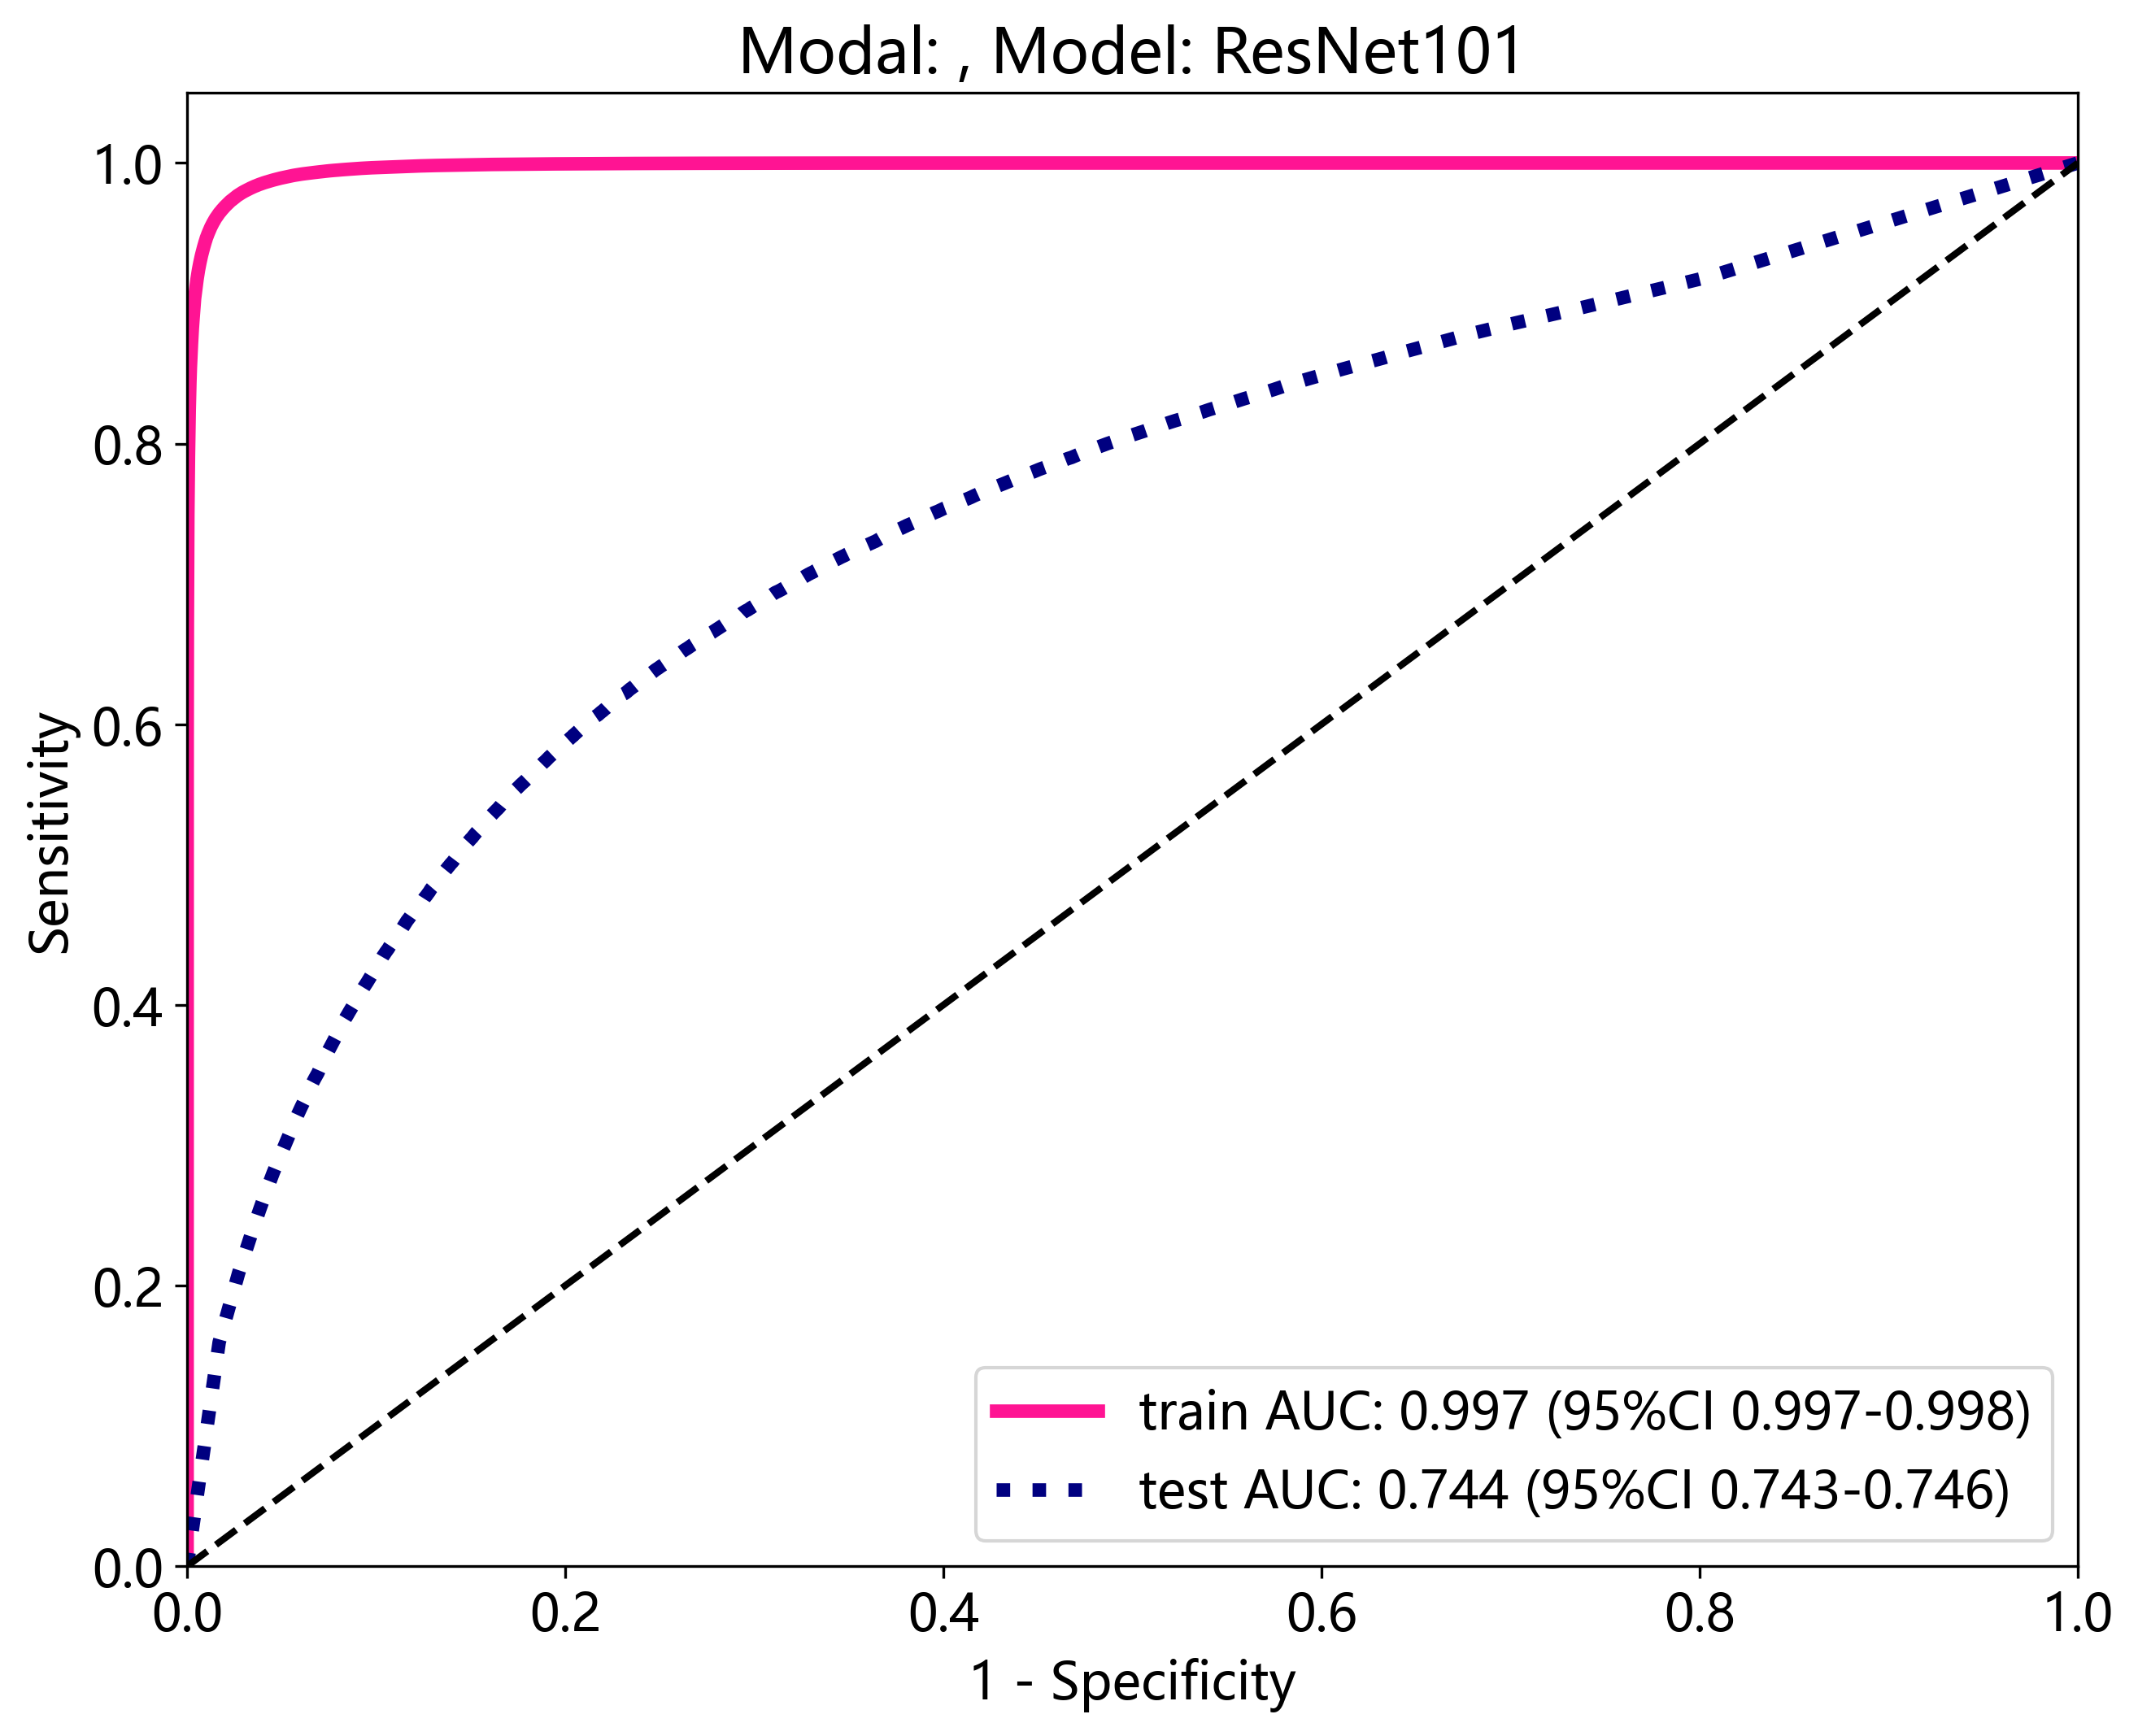

 29 8 train (1268349, 7)
 29 8 test (421943, 7)


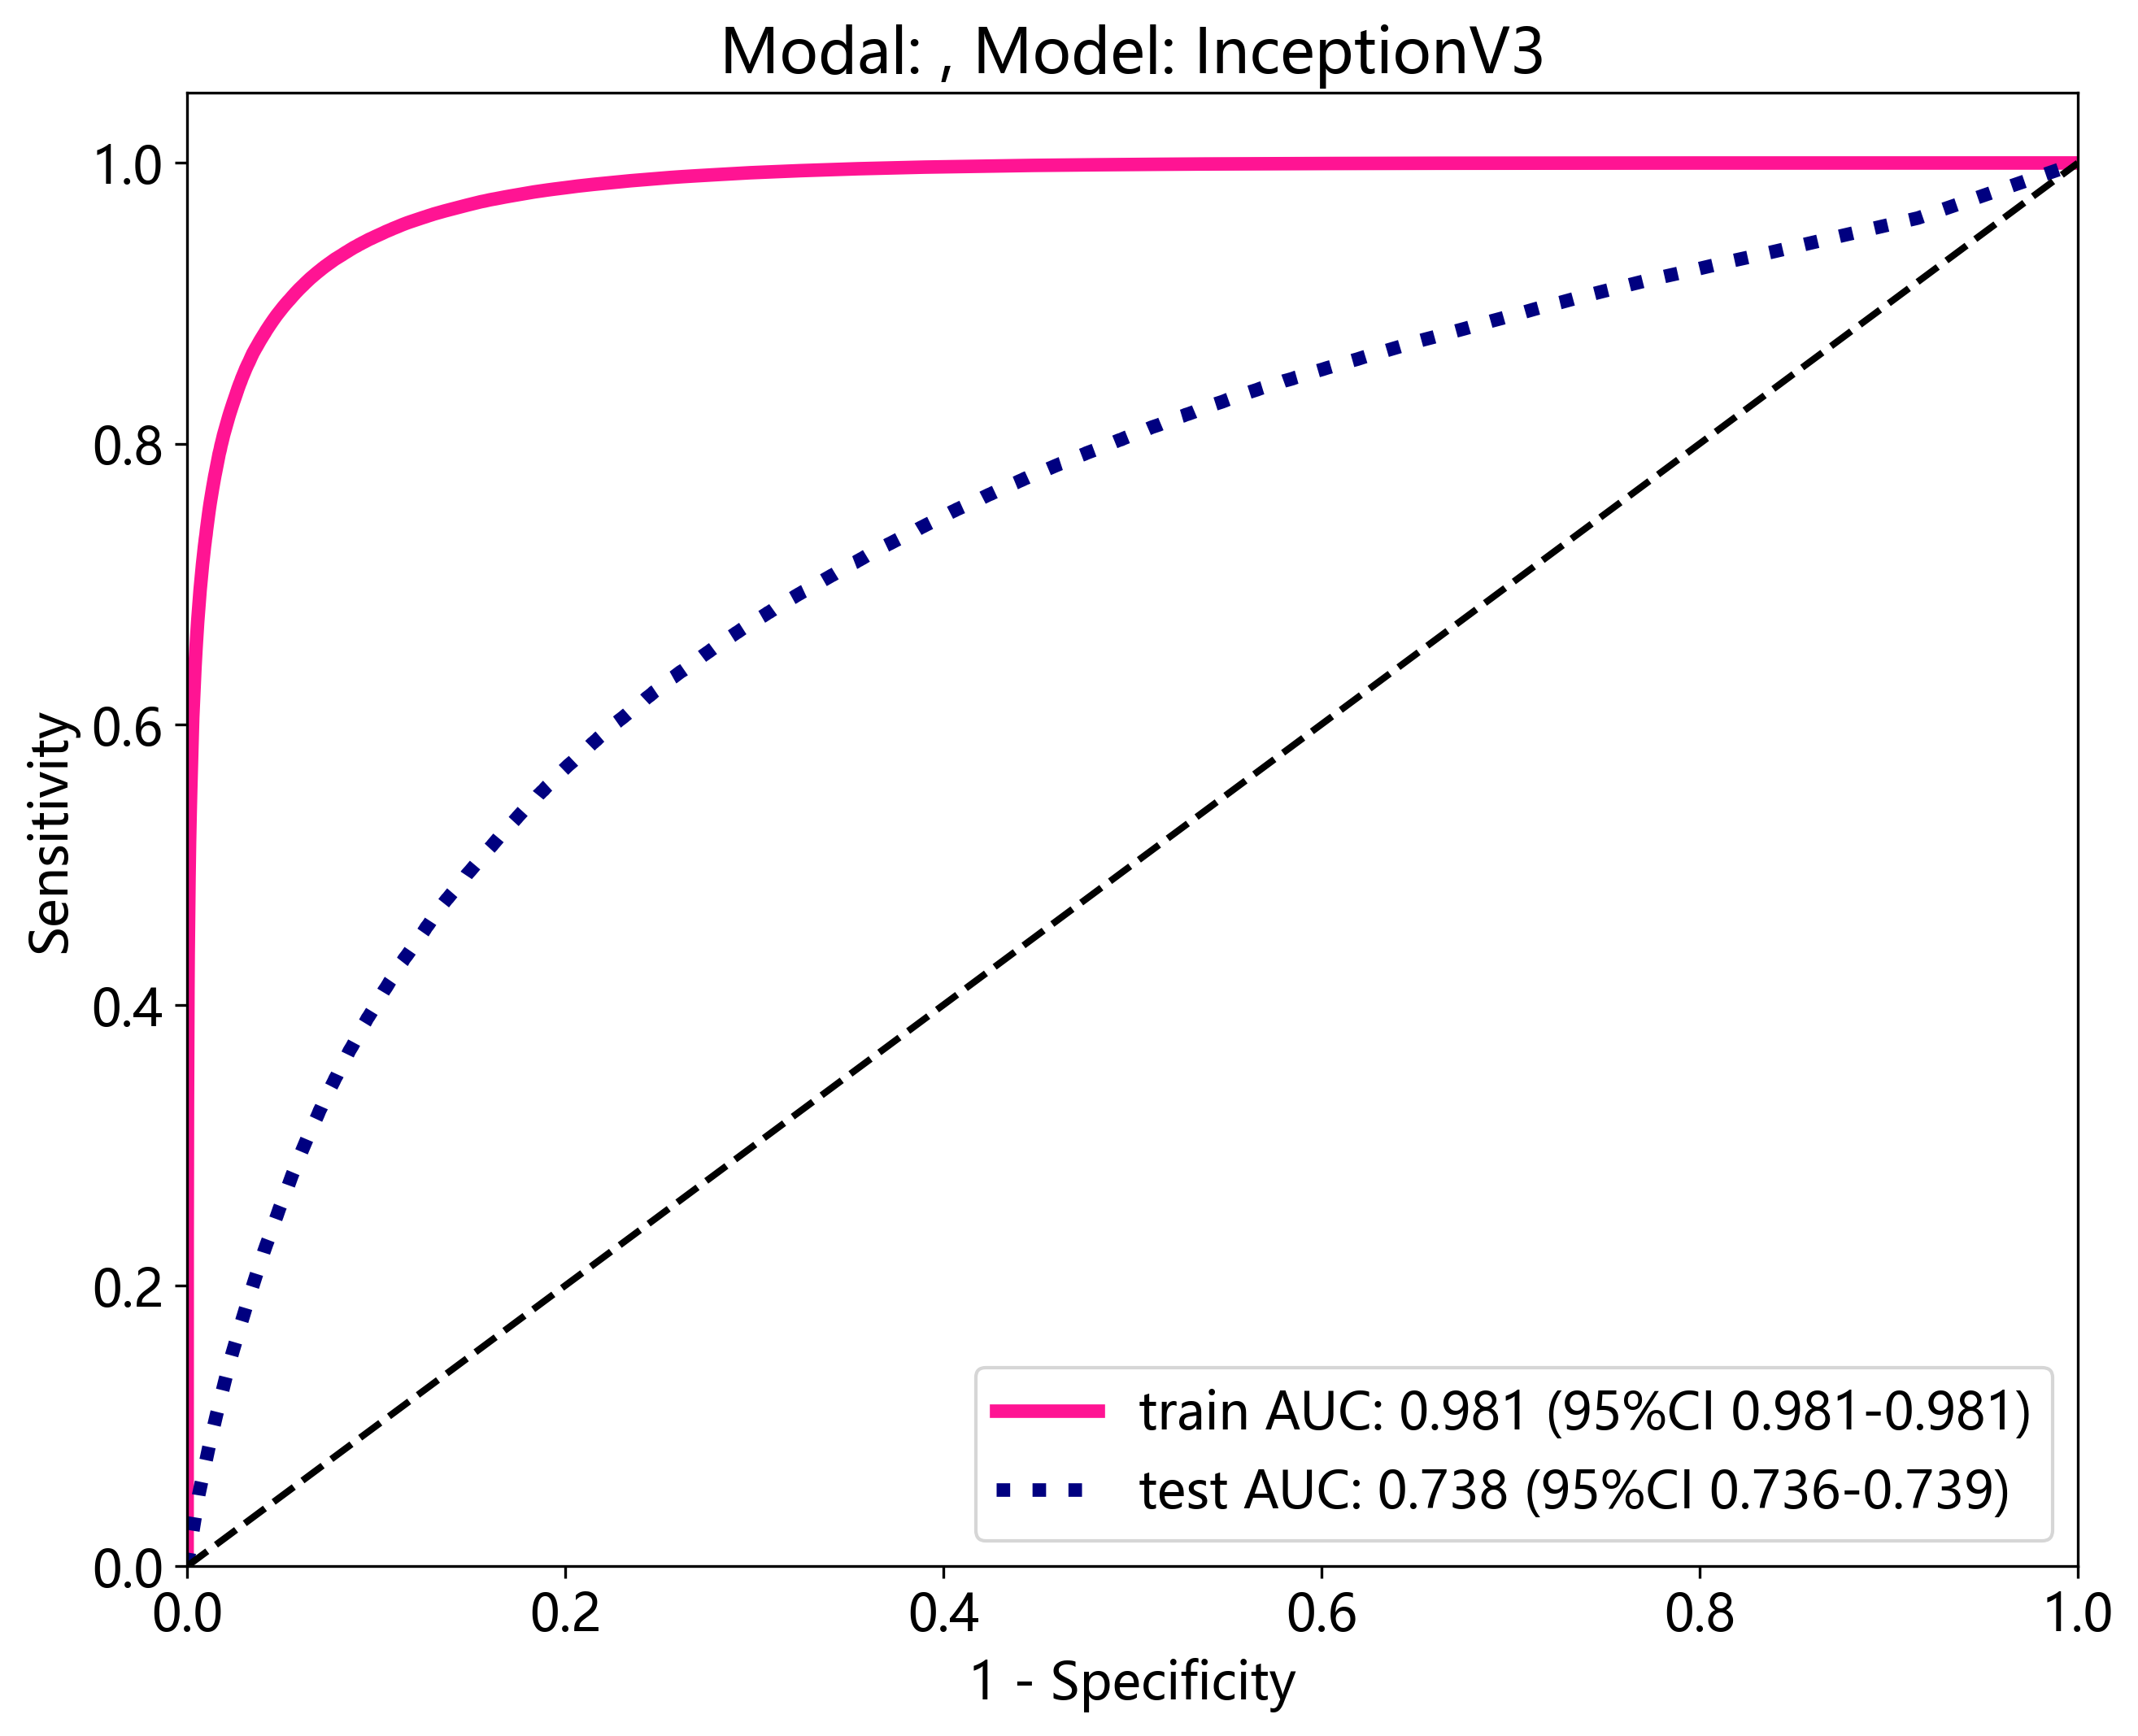

,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Youden,Modal,Cohort
0,densenet121,0.956,0.993,0.9927-0.9929,0.955,0.957,0.965,0.945,0.564,,train
1,densenet121,0.685,0.735,0.7331-0.7361,0.627,0.739,0.696,0.675,0.514,,test
2,resnet101,0.975,0.997,0.9974-0.9975,0.977,0.974,0.979,0.971,0.534,,train
3,resnet101,0.697,0.744,0.7426-0.7456,0.638,0.753,0.711,0.686,0.502,,test
4,inception_v3,0.927,0.981,0.9810-0.9814,0.926,0.927,0.940,0.910,0.558,,train
5,inception_v3,0.689,0.738,0.7363-0.7393,0.633,0.744,0.702,0.680,0.547,,test


,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Youden,Modal,Cohort
0,densenet121,0.956,0.993,0.9927-0.9929,0.955,0.957,0.965,0.945,0.564,,train
1,densenet121,0.685,0.735,0.7331-0.7361,0.627,0.739,0.696,0.675,0.514,,test
2,resnet101,0.975,0.997,0.9974-0.9975,0.977,0.974,0.979,0.971,0.534,,train
3,resnet101,0.697,0.744,0.7426-0.7456,0.638,0.753,0.711,0.686,0.502,,test
4,inception_v3,0.927,0.981,0.9810-0.9814,0.926,0.927,0.940,0.910,0.558,,train
5,inception_v3,0.689,0.738,0.7363-0.7393,0.633,0.744,0.702,0.680,0.547,,test


In [3]:
import pandas as pd
import numpy  as np
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.comp1 import draw_roc
from onekey_algo.custom.components.ugly import drop_error
from matplotlib import pyplot as plt


def get_log(log_path, map2gz:bool = True):
    log_ = pd.read_csv(log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
    if map2gz:
        log_['ID'] = log_['fname'].map(lambda x: os.path.basename(x).split('_')[0] + '.nii.gz')
    else:
        log_['ID'] = log_['fname'].map(lambda x: os.path.basename(x).split('_')[0])
    return log_

def map_mn(x):
    return x.replace('densen', 'DenseN').replace('resnet', 'ResNet').replace('vgg', 'VGG').replace('inception_v3', 'InceptionV3')

all_log = []
metrics_dfs = []
epoch_mapping = {'densenet121': {'T1C': 25, 'T2': 12,},
                 'resnet101': {'T1C': 15, 'T2': 20,},
                 'inception_v3': {'T1C': 11, 'T2': 19,}}
dsamples = {'val': set(), 'test': set()}
for modal in ['']:
    for epoch_ in range(29, 30):
        for cv in range(8, 9):
            model_root = os.path.join(get_param_in_cwd('data_root'), 'models')
            metric_results = []
            all_preds = []
            all_gts = []
            all_model_names = []
            for model in ['densenet121', 'resnet101', 'inception_v3']:
                if model != 'inception_v3' and False:
                    continue
                all_pred = []
                all_gt = []
                all_groups = []
                val_log = pd.concat([get_log(os.path.join(model_root, model, f"viz/BST_TRAIN_RESULTS.txt")),
                                    get_log(os.path.join(model_root, model, f"viz/BST_VAL_RESULTS.txt"))], axis=0)
#                 val_log = pd.concat([get_log(os.path.join(model_root, model, f"train/Epoch-{epoch_}.txt")),
#                                     get_log(os.path.join(model_root, model, f"valid/Epoch-{epoch_}.txt"))], axis=0)
#                 val_log = pd.concat([get_log(os.path.join(model_root, model, f"train/Epoch-{epoch_mapping[model][modal]}.txt")),
#                                     get_log(os.path.join(model_root, model, f"valid/Epoch-{epoch_mapping[model][modal]}.txt"))], axis=0)
                
                val_log = pd.merge(val_log, group, on='ID', how='inner')
                val_log['model'] = f"{model}_{modal}"                
                val_log = val_log[val_log['fname'].str.contains(modal)]
#                 display(val_log)
                ug_groups = np.unique(val_log['group'])
                ug_groups = ['train', 'test']
                ul_labels = np.unique(val_log['pred_label'])
                for g in ug_groups:
                    sub_group = val_log[val_log['group'] == g]
                    if g in ['val', 'test']:
                        if modal in ['T1_facet', 'T2_facet'] and model == 'ShuffleNet':
                            if len(dsamples[g]) < (8 if g == 'val' else 8):
                                sel_idx, = drop_error([sub_group['pred_label']], [sub_group['gt']], [sub_group['pred_score']], 
                                                      ratio=5 if modal == 'T1_facet' else 4, verbose=True)
                                print(g, sub_group.shape, sub_group[sel_idx].shape, 
                                      set(sub_group['fname'])-set(sub_group[sel_idx]['fname']))
                                drop_s = set(sub_group['fname'])-set(sub_group[sel_idx]['fname'])
                                dsamples[g] |= set([os.path.basename(s).replace('.png', '.gz') for s in drop_s])
                        sub_group = sub_group[~sub_group['ID'].isin(dsamples[g])]
#                         print(dsamples)
                    print(modal, epoch_, cv, g, sub_group.shape)
                    all_log.append(sub_group)
                    sub_group['label-1'] = list(map(lambda x: x[0] if x[1] == 1 else 1-x[0], 
                                                    np.array(sub_group[['pred_score', 'pred_label']])))
                    sub_group['label-0'] = 1 - sub_group['label-1']
                    sub_group[['ID', 'label-0', 'label-1']].to_csv(os.path.join('results', f'{modal}_DL_{model}_{g}.csv'), index=False)
                    all_groups.append(g)
                    for ul in [1]:
                        pred_score = np.array(sub_group['label-1'])
                        gt = [1 if gt_ == ul else 0 for gt_ in np.array(sub_group['gt'])]
                        acc, auc, ci, tpr, tnr, ppv, npv, _, _, _, thres = metrics.analysis_pred_binary(gt, pred_score, use_youden=True)
                        ci = f"{ci[0]:.4f}-{ci[1]:.4f}"
                        metric_results.append([model, acc, auc, ci, tpr, tnr, ppv, npv, thres, modal, g])
                        all_pred.append(pred_score)
                        all_gt.append(gt)
                # 绘制每个模型的ROC
                draw_roc(all_gt, all_pred, labels=all_groups, title=f"{modal}, Model: {map_mn(model)}")
                plt.savefig(f'img/{modal}_Path_{model}_roc.svg', bbox_inches='tight')
                plt.show()
                # 整合到所有模型汇总。
                all_preds.extend(all_pred)
                all_gts.extend(all_gt)
                all_model_names.append(model)
#             for gi, g in enumerate(all_groups):
#                 draw_roc(all_gts[gi::len(all_groups)], all_preds[gi::len(all_groups)], labels=all_model_names, 
#                          title=f"Modal {modal}, Cohort {g}")
#                 plt.savefig(f'img/{modal}_DTL_{g}_roc.svg', bbox_inches='tight')
#                 plt.show()
            metrics_df = pd.DataFrame(metric_results, 
                         columns=['ModelName', 'Acc', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 
                                  'Youden', 'Modal', 'Cohort'])
            display(metrics_df)
            metrics_dfs.append(metrics_df)
            
all_log = pd.concat(all_log, axis=0)
all_log['ID'] = all_log['fname'].map(lambda x: os.path.basename(x))
pd.concat(metrics_dfs, axis=0)

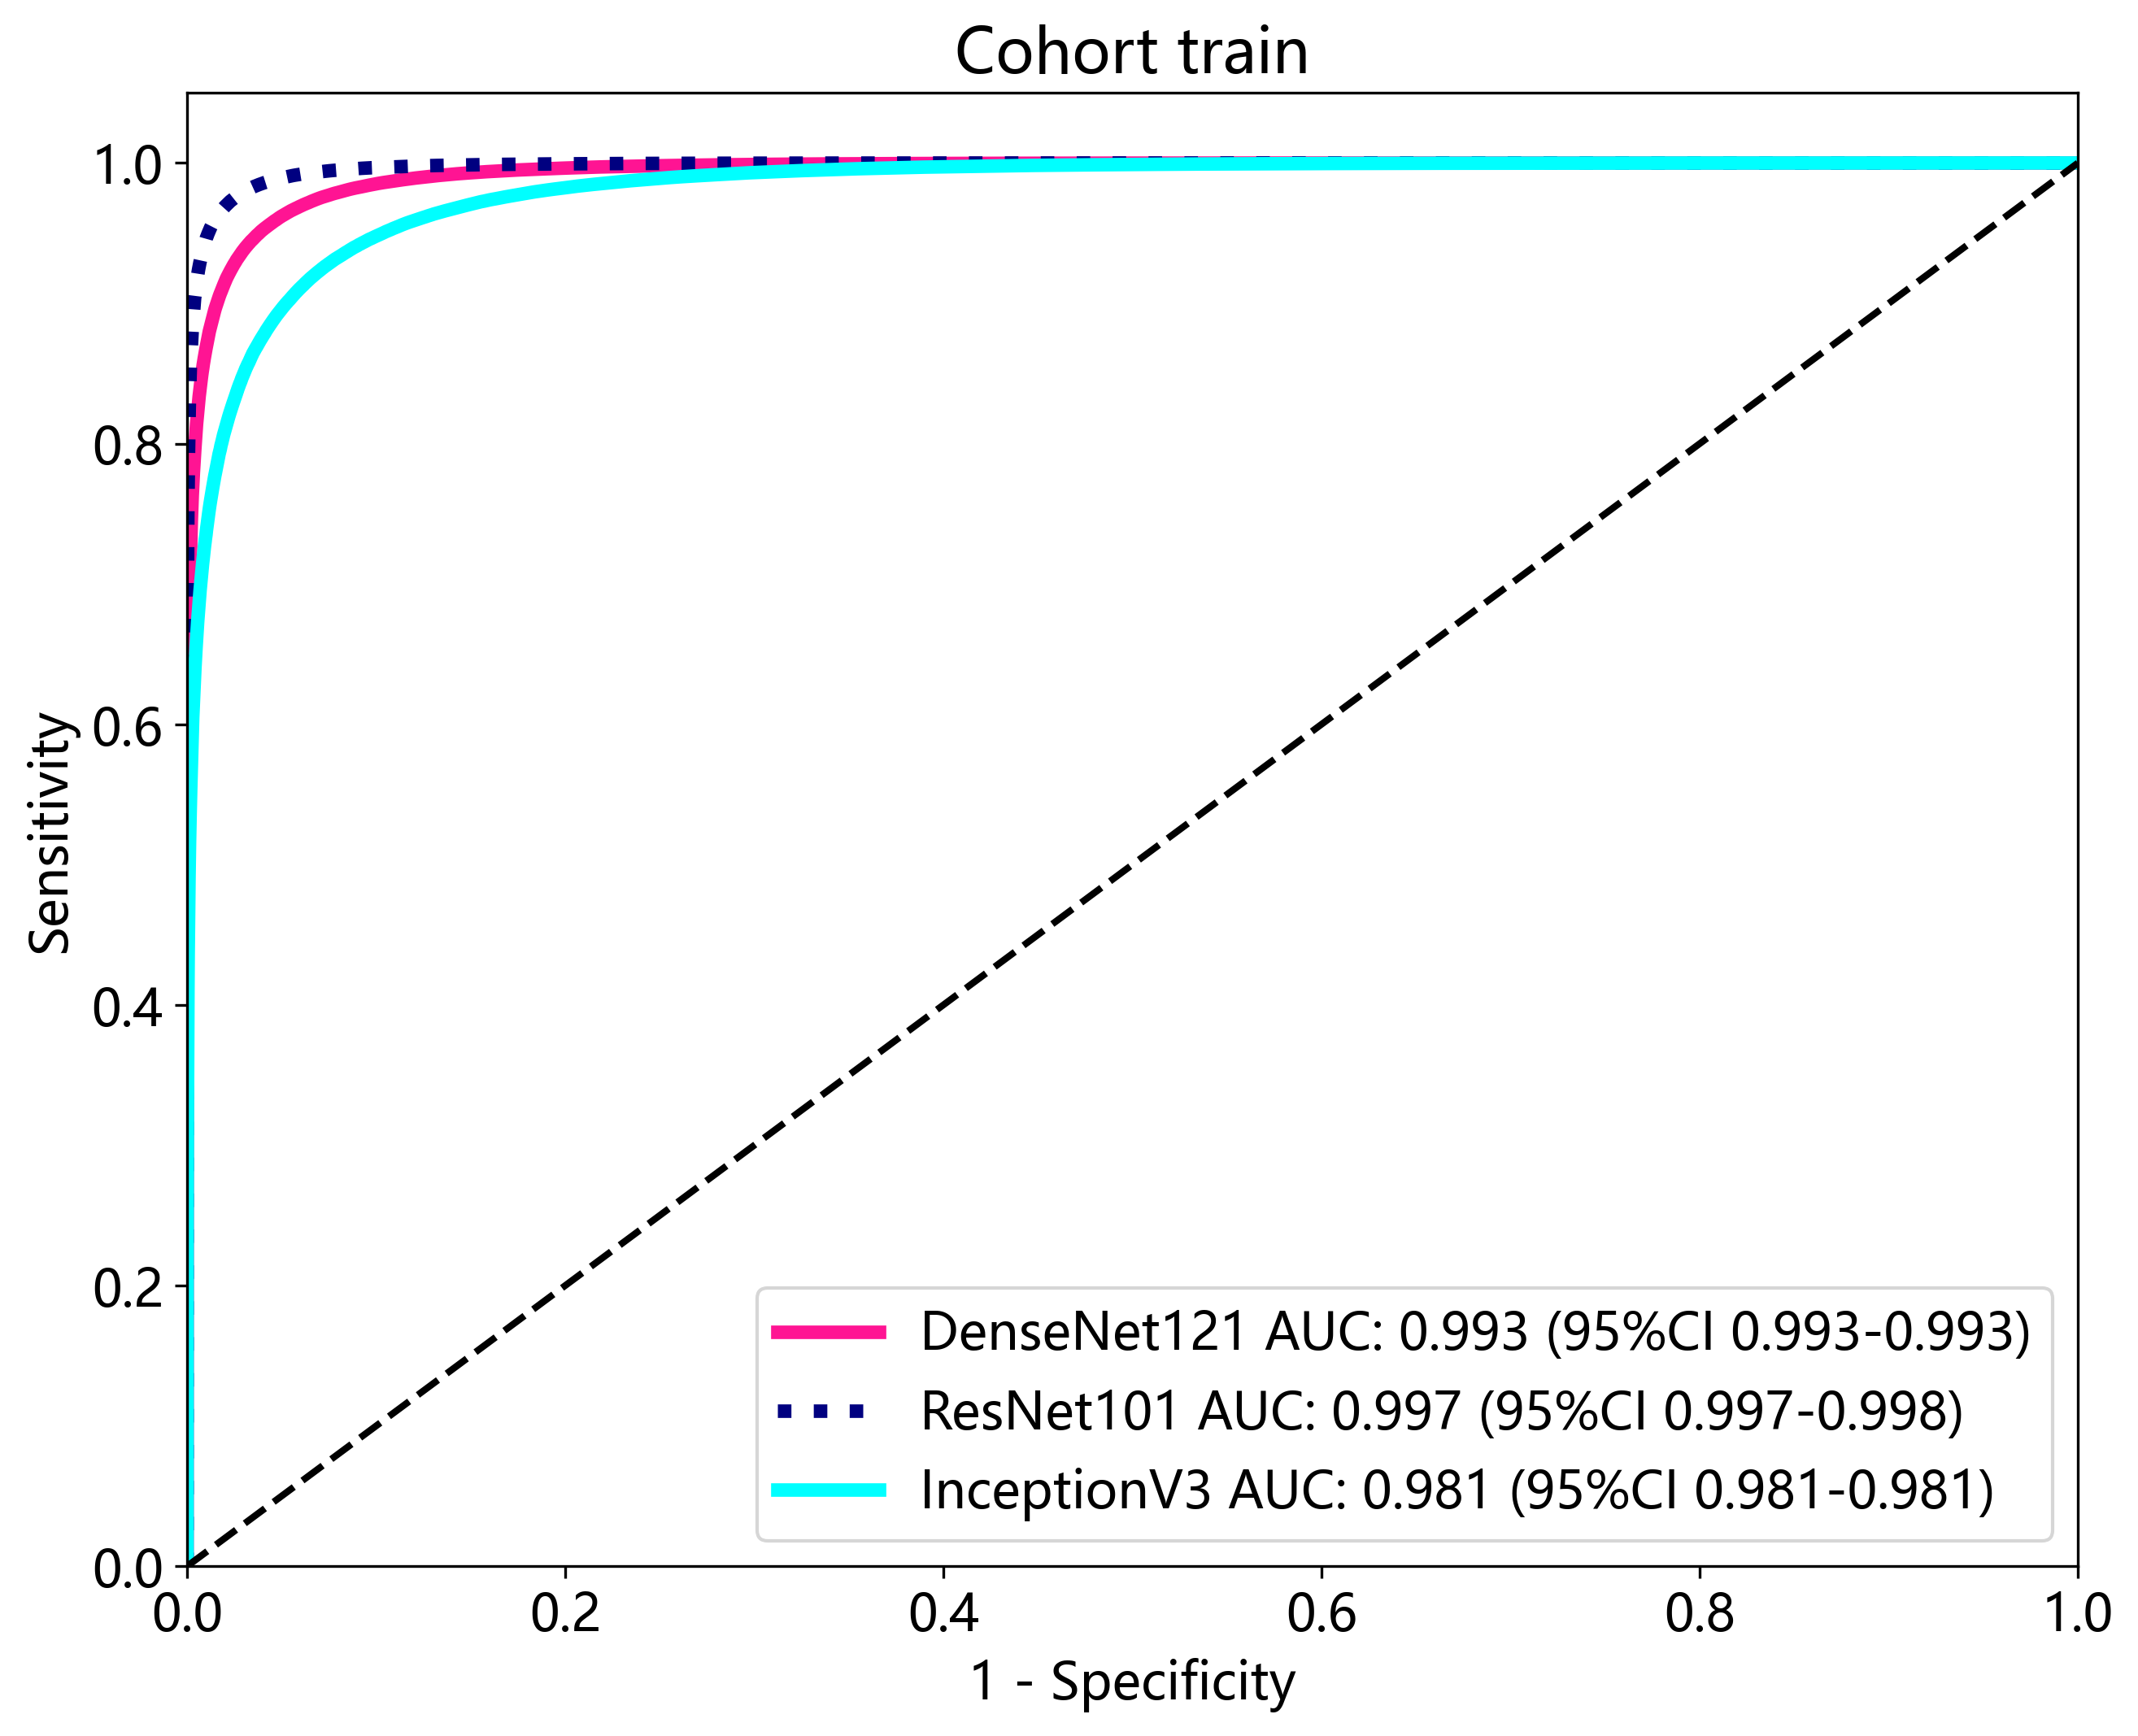

[2024-03-13 23:19:28 - comp1.py: 342]	WARNING	输入数据量不相等，我们将忽略多余的数据！


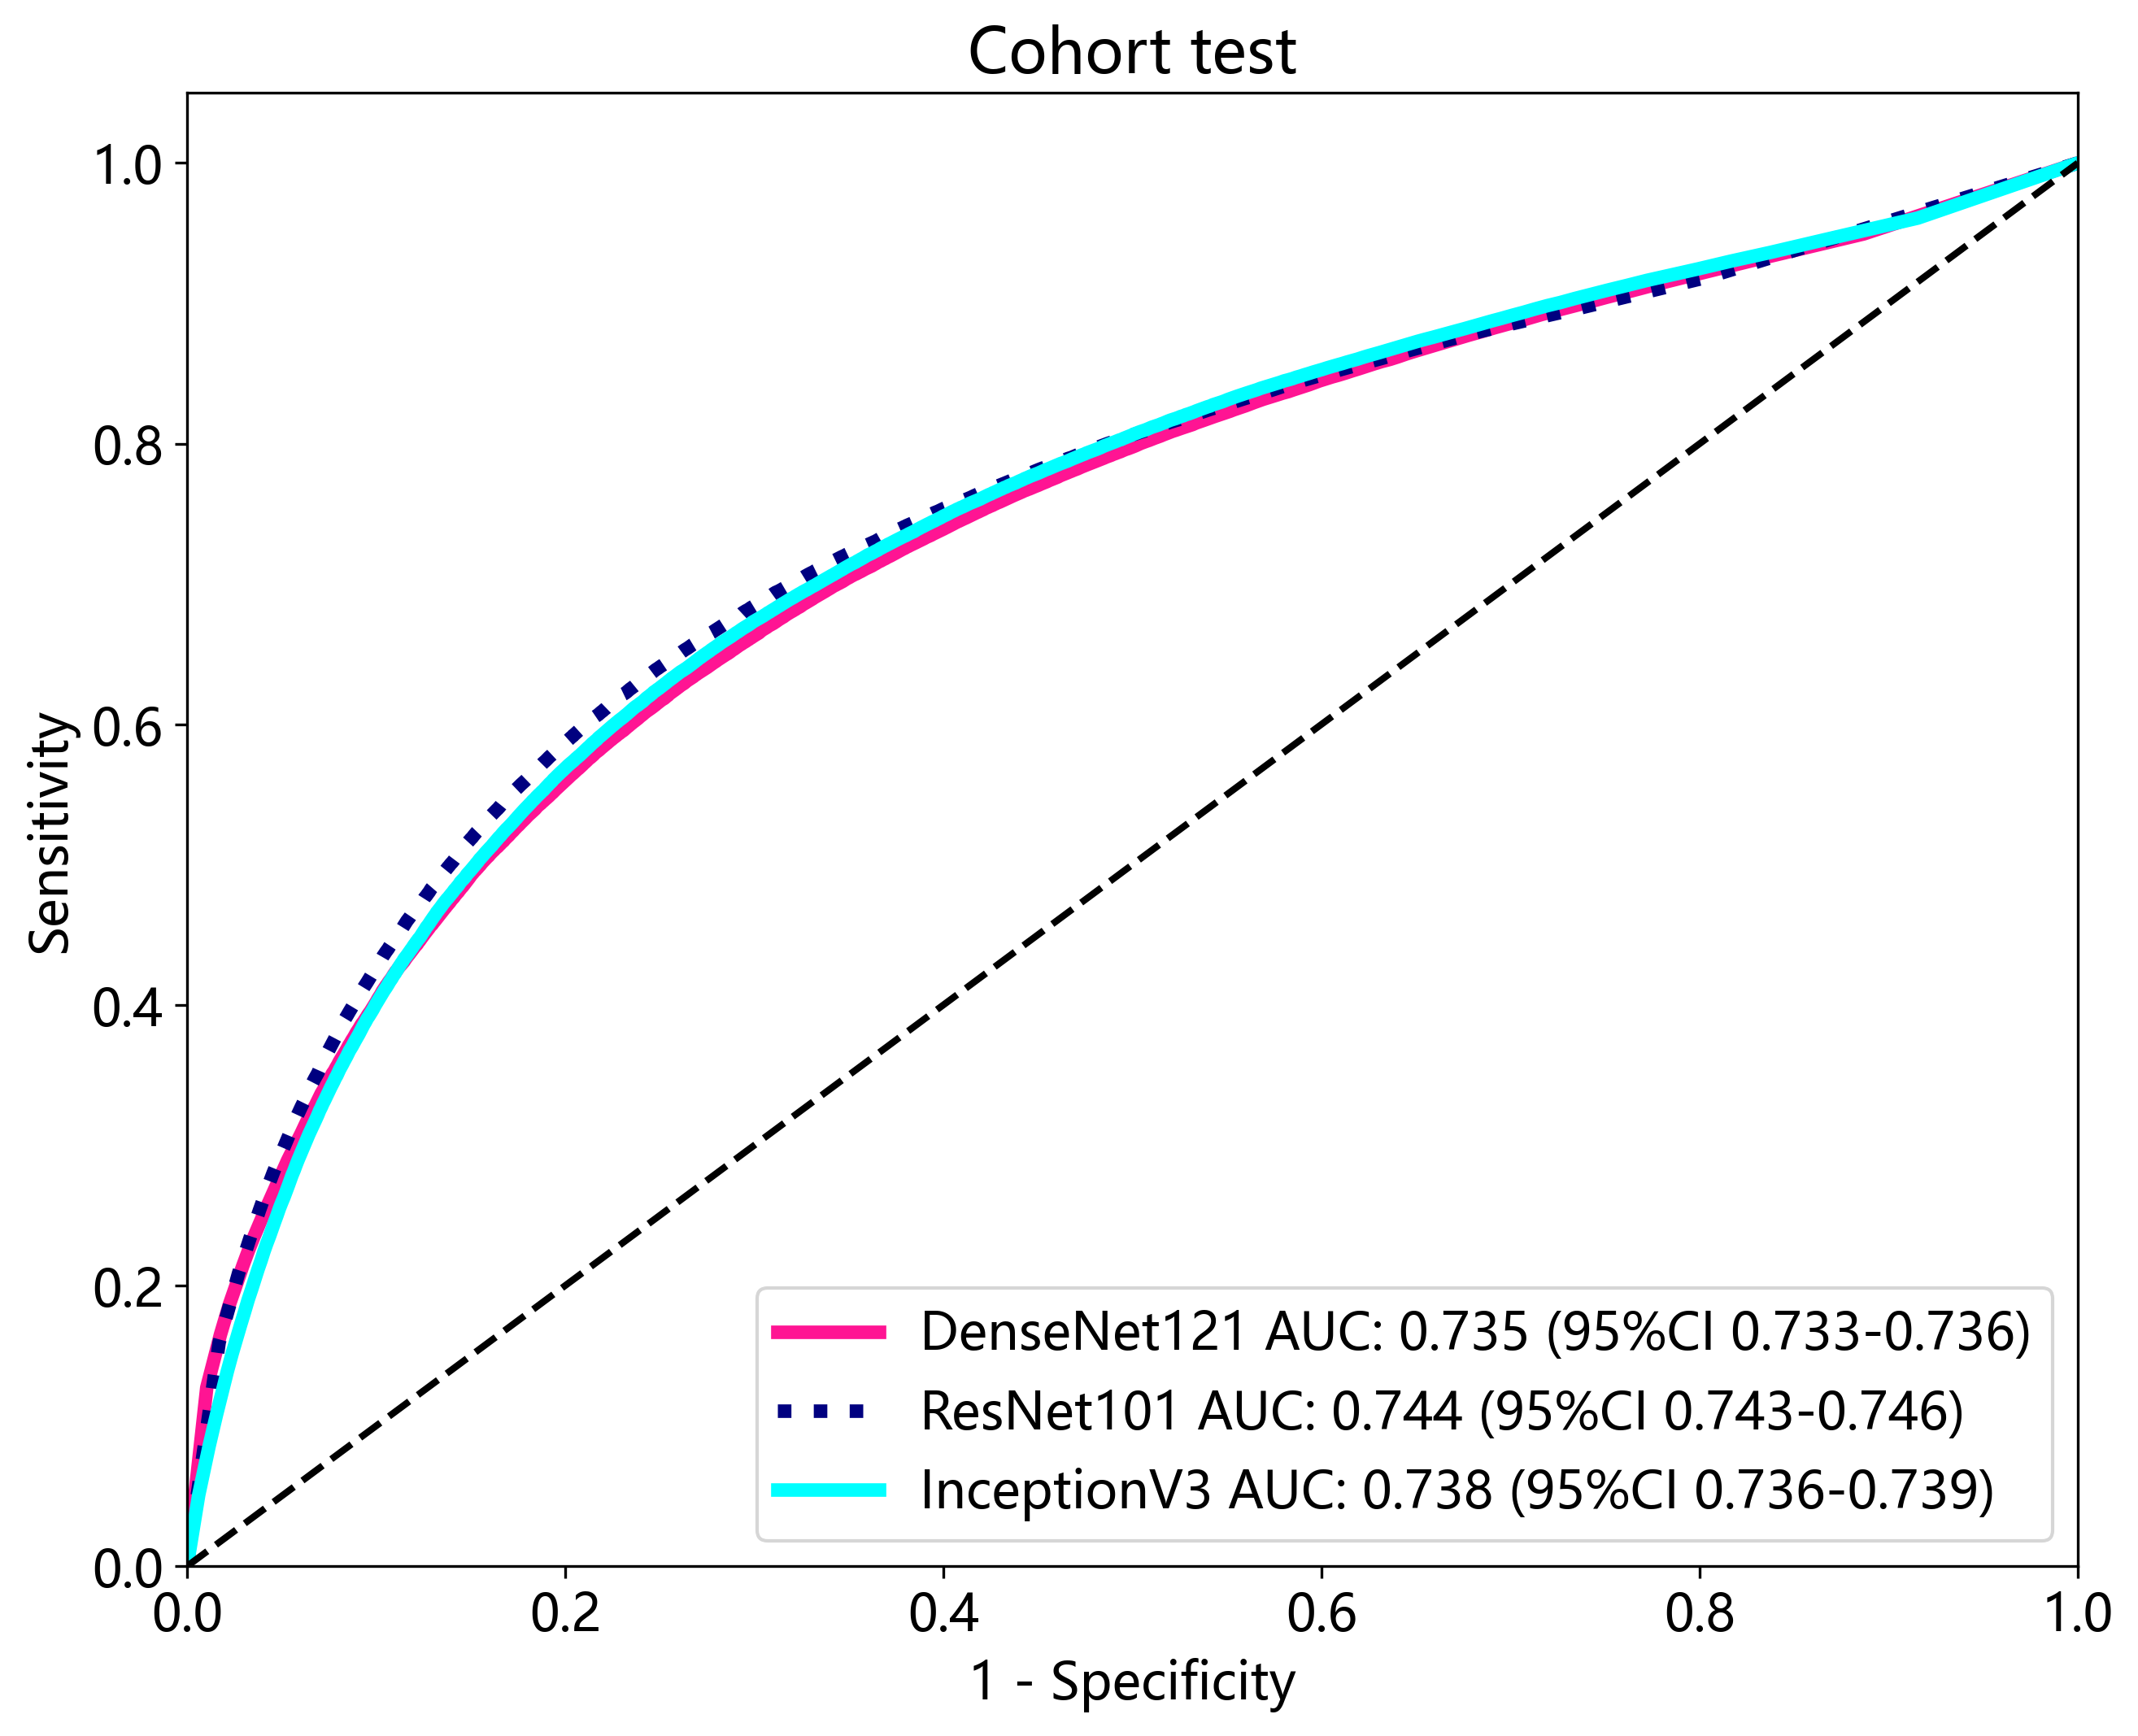

In [7]:
import pandas as pd
import os
from onekey_algo.custom.components.ugly import drop_error
import numpy as np
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.comp1 import draw_roc
import matplotlib.pyplot as plt
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
metric_results = []
dtl = []

model_root = os.path.join(get_param_in_cwd('data_root'), 'models')
mn = []
for epoch in range(1):
    for subset in ['train', 'test']:
        all_pred = []
        all_gt = []
        for model in ['densenet121', 'resnet101', 'inception_v3']:
#             if model == 'resnet50':
#                 continue
            mn.append(map_mn(model))
            train_log_path = os.path.join(model_root, rf'{model}/viz/BST_TRAIN_RESULTS.txt')
#             train_log_path = rf'{model_root}/{model}/train/Epoch-{sm[model]}.txt'
            train_log = pd.read_csv(train_log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
            train_log['group'] = 'train'
            val_log_path = os.path.join(model_root, rf'{model}/viz/BST_VAL_RESULTS.txt')
#             val_log_path = rf'{model_root}/{model}/valid/Epoch-{sm[model]}.txt'
            val_log = pd.read_csv(val_log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
            val_log['group'] = 'test'
            log = pd.concat([train_log, val_log], axis=0)
            log['ID'] = log['fname'].map(lambda x: os.path.basename(x).split('_')[0] + '.nii.gz')
            log = pd.merge(log, group[['ID']], on='ID', how='inner')
            val_log = log[log['group'] == subset]
            ul_labels = np.unique(val_log['pred_label'])
            pred_score = list(map(lambda x: x[0] if x[1] == 1 else 1-x[0], np.array(val_log[['pred_score', 'pred_label']])))
            gt = [1 if gt_ == 1 else 0 for gt_ in np.array(val_log['gt'])]
            all_pred.append(np.array(list(map(lambda x: (1-x[0], x[0]) if x[1] == 1 else (x[0], 1-x[0]), 
                                              np.array(val_log[['pred_score', 'pred_label']])))))
            all_gt.append(gt)

        draw_roc(all_gt, all_pred, labels=mn, title=f"Cohort {subset}")
        plt.savefig(f'img/Path_model_{subset}_roc.svg', bbox_inches = 'tight')
        plt.show()